In [103]:
from modules import get_trend
from modules import prepare_data
from modules import split_data
from modules import get_data_for_new_predict
from modules import get_new_data
from modules import catboost_split_data
from modules import get_prob_data
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
import optuna

prob_const = 0.6

In [95]:
# Загружаем датасет из файла, форируем модифицированный датасет с установленным индексом по ключу Symbol
data = pd.read_csv("C:/Programs/Projects/IPO/kaggle/input/financial-ipo-data/IPODataFull.csv",
                   encoding="ISO-8859-1", low_memory=False)
data_index = data.set_index('Symbol')

In [96]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

price_start_position = 8
price_stop_position = 1318
price_step = 5
roll_window = 5
diff_step = 2
trend_const = 10
profitably_const = 0.3

In [97]:
# Функция, которая:
# 1. Формирует новый df,состоящий только из цен закрытия за все 262 дня
# 2. Заменяет каждое значение цены средним за предыдущие 5 дней
# 3. Вычисляет разницу 2-х значений усредненных цен с шагом 2, затем сумируем все разницы
# 3. Заменяет каждое значение получившейся серии по условию:
# если сумма отрицательная - бычий тренд, -1, больше 10 - медвежий, 1.
# В ином случае - считаем, что тренд невыраженный, нулевой (то есть за год цена значительно не выросла и не упала).
# После этого функция добавляет к входному датасету новый столбец Trend со значениями тренда
# Также функция добавляет столбец financialResult в котором отражено на сколько процентов изменилась цена
# и столбец is_profit как показатель прибыльности акции
def get_trend(input_df):
    df = input_df.iloc[:, price_start_position:price_stop_position:price_step].copy()
    df = df.rolling(roll_window, axis=1).mean()
    df = df.diff(diff_step, axis=1).sum(axis=1)
    df[df < 0] = -1
    df[(df > 0) & (df <= trend_const)] = 0
    df[df > trend_const] = 1
    df = df.astype(int)
    input_df['trend'] = df
    input_df['financialResult'] = (input_df['closeDay93'] - input_df['closeDay0']) / input_df['closeDay0']
    input_df['is_profit'] = input_df['financialResult'] >= profitably_const
    input_df.is_profit[input_df['is_profit']] = 1
    return 0

get_trend(data_index)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

In [98]:
# Функция предобработки данных. Вычищает спецсимволы, пробелы, приводит численные колонки к типу float,
# убирает пустые значения
def prepare_data(input_df):
    prepared_data = input_df[['MarketCap', 'Industry', 'Revenue', 'netIncome',
                              'employees', 'YearFounded', 'is_profit']].copy()

    prepared_data = prepared_data.replace(r'\$', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(' ', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(',', '.', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\(', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\)', '', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('B', '0000000', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace('M', '0000', regex=True)
    prepared_data[['Revenue']] = prepared_data[['Revenue']].replace(r'\.', '', regex=True).astype(float)

    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(' ', '', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(',', '.', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('B', '0000000', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace('M', '0000', regex=True)
    prepared_data[['netIncome']] = prepared_data[['netIncome']].replace(r'\.', '', regex=True).astype(float)

    prepared_data[['Industry']] = prepared_data[['Industry']].astype(str)

    prepared_data[['employees']] = prepared_data[['employees']].replace('-', '0', regex=True)
    prepared_data[['employees']] = prepared_data[['employees']].astype(float)

    prepared_data = prepared_data.replace([np.inf, -np.inf], np.nan)
    prepared_data.fillna(0, inplace=True)
    return prepared_data

prepared_df = prepare_data(data_index)

In [13]:
# xx = prepared_df.iloc[:, :6]
# label_encoder = LabelEncoder()
# xx['Encode_Industry'] = label_encoder.fit_transform(xx.iloc[:, 1])
# xx.to_excel("C:/Programs/Projects/IPO/Industry_encoding.xlsx")

In [99]:
# Функция расщепления данных на тренировочный и тетсовый наборы для первичного обучения модели.
# Также перекодирует строковую фичу "Industry".
def split_data(input_df):
    x = input_df.iloc[:, :6]
    y = input_df.is_profit
    label_encoder = LabelEncoder()
    x.iloc[:, 1] = label_encoder.fit_transform(x.iloc[:, 1])
    y.astype(int)
    x_train, x_test, y_tr, y_tes = train_test_split(x, y, random_state=0)
    return x_train, x_test, y_tr, y_tes

X_train, X_test, y_train, y_test = split_data(prepared_df)

In [100]:
# Функция подготовки данных для обучения модели для предсказания новых элементов.
# Не расщепляет исходный датасет для увеличения мощности обучающей выборки.
# Также перекодирует строковую фичу "Industry".
def get_data_for_new_predict(input_df):
    x = input_df.iloc[:, :6]
    y = input_df.is_profit
    label_encoder = LabelEncoder()
    x.iloc[:, 1] = label_encoder.fit_transform(x.iloc[:, 1])
    y.astype(int)
    return x, y

# Готовим полные выборки для предсказания новых IPO
X, y = get_data_for_new_predict(prepared_df)

In [101]:
# Функция, формирующая датафрей с новыми компаниями для предсказания.
def get_new_data(symbol, market_cap, industry, revenue, net_income, employees, year_founded):
    x_new = pd.DataFrame(data={'Symbol': symbol,
                               'MarketCap': market_cap,
                               'Industry': industry,
                               'Revenue': revenue,
                               'netIncome': net_income,
                               'employees': employees,
                               'YearFounded': year_founded})
    x_new = x_new.set_index('Symbol')
    return x_new

X_new = get_new_data(['DLO', 'MQ', 'MNDY', 'ZETA'],
                     [4979640000, 11665500000, 5792900000, 2107930000],
                     [22, 29, 29, 29],
                     [104140000, 290300000, 161100000, 368120000],
                     [28190000, 47700000, -152200000, -53230000],
                     [365, 509, 799, 1296],
                     [2016, 2010, 2012, 2007])

In [23]:
# Изначально былав композиция из 3-х моделей, но по результатам тестирования Catboost всю малину обсирает, 
# поэтому был исключен из финальной версии
# # Оптимизируем модель Catboost на изначальном датасете
# #cat_features = [0, 1]
# train_pool = Pool(X_train, label=y_train)
# test_pool = Pool(X_test, label=y_test)

# best_catboost_model = CatBoostClassifier(
#    bagging_temperature=1,
#    random_strength=1,
#    thread_count=3,
#    iterations=1000,
#    l2_leaf_reg=4.0,
#    learning_rate=0.07521709965938336,
#    random_seed=63,
#    od_type='Iter',
#    od_wait=20,
#    custom_loss=['AUC:hints=skip_train~false'],
#    use_best_model=True
# )

# # Обучаем модель Catboost
# best_catboost_model.fit(
#    train_pool,
#    eval_set=test_pool,
#    logging_level='Silent',
#    plot=True
# )

# # Предсказание Catboost
# catboost_prob = best_catboost_model.predict_proba(X_new)[:, 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

array([0.30371757])

In [126]:
# Функция для оптимизации гиперпараметров для LightGBM
def objective(trial):
    data_train = lgb.Dataset(X_train, label=y_train)
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "rf"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 1002, 100),
        "n_estimators": trial.suggest_int("n_estimators", 2, 1002, 100),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 100000, 500000, 1000),
    }

    lgbm = lgb.train(param, data_train)
    predictions = lgbm.predict(X_test)
    prediction_labels = np.rint(predictions)
    accuracy = f1_score(y_test, pd.Series(prediction_labels), average='binary') # пробуем f1 с бинарными опциями
    return accuracy


# Обучаем модель LightGBM, оптимизируя гиперпараметры с помощью Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=False)
best_lgb_parameters = study.best_params
best_lgb_clf = lgb.LGBMClassifier(**study.best_params)

best_lgb_clf.fit(X, y)

lgb_prob = best_lgb_clf.predict_proba(X_new)[:, 1]
lgb_prob

[I 2021-06-03 18:09:36,905] A new study created in memory with name: no-name-500ade1e-7a61-444e-aaa4-c9fca9de495c
[I 2021-06-03 18:09:37,084] Trial 5 finished with value: 0.22406639004149376 and parameters: {'boosting_type': 'rf', 'lambda_l1': 3.6759992060602536e-05, 'lambda_l2': 8.692653169817817e-08, 'num_leaves': 200, 'feature_fraction': 0.8480572874481522, 'bagging_fraction': 0.4511488598886038, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 802, 'n_estimators': 2, 'subsample_for_bin': 112000}. Best is trial 5 with value: 0.22406639004149376.
[I 2021-06-03 18:09:37,115] Trial 6 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.00036789235762327055, 'lambda_l2': 4.5363151529349185e-06, 'num_leaves': 23, 'feature_fraction': 0.751702541927711, 'bagging_fraction': 0.5793355846850978, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 2, 'n_estimators': 2, 'subsample_for_bin': 165000}. Best is trial 5 with value: 0.22406639004149376.
[I 20

[I 2021-06-03 18:09:42,772] Trial 23 finished with value: 0.32258064516129037 and parameters: {'boosting_type': 'dart', 'lambda_l1': 8.254807966446982, 'lambda_l2': 9.205362152109458, 'num_leaves': 166, 'feature_fraction': 0.9854888613922472, 'bagging_fraction': 0.9945818101491583, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 602, 'n_estimators': 202, 'subsample_for_bin': 322000}. Best is trial 17 with value: 0.35666666666666663.
[I 2021-06-03 18:09:43,121] Trial 22 finished with value: 0.3333333333333333 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.202575252275205, 'lambda_l2': 0.880354652748226, 'num_leaves': 170, 'feature_fraction': 0.9946670069221641, 'bagging_fraction': 0.9826292230205478, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 602, 'n_estimators': 302, 'subsample_for_bin': 304000}. Best is trial 17 with value: 0.35666666666666663.
[I 2021-06-03 18:09:43,626] Trial 25 finished with value: 0.07142857142857142 and parameters: {'boosting_type':

[I 2021-06-03 18:09:52,183] Trial 39 finished with value: 0.348993288590604 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.2151804210404884, 'lambda_l2': 0.004970200641945112, 'num_leaves': 132, 'feature_fraction': 0.4059746452355772, 'bagging_fraction': 0.6423597249982823, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 1002, 'n_estimators': 102, 'subsample_for_bin': 176000}. Best is trial 17 with value: 0.35666666666666663.
[I 2021-06-03 18:09:52,599] Trial 40 finished with value: 0.3524590163934426 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.6895250315259032, 'lambda_l2': 0.004727999977465773, 'num_leaves': 116, 'feature_fraction': 0.4383607592185666, 'bagging_fraction': 0.629806938408334, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 902, 'n_estimators': 102, 'subsample_for_bin': 186000}. Best is trial 17 with value: 0.35666666666666663.
[I 2021-06-03 18:09:52,744] Trial 44 finished with value: 0.35135135135135137 and parameters: {'boostin

[I 2021-06-03 18:09:55,208] Trial 61 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 0.4810011627846405, 'lambda_l2': 0.001385920279860051, 'num_leaves': 106, 'feature_fraction': 0.4922701903296801, 'bagging_fraction': 0.4289759951017702, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 302, 'n_estimators': 602, 'subsample_for_bin': 221000}. Best is trial 17 with value: 0.35666666666666663.
[I 2021-06-03 18:09:55,276] Trial 32 finished with value: 0.10362694300518135 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.13418003948125667, 'lambda_l2': 0.003270682959450003, 'num_leaves': 145, 'feature_fraction': 0.5605573277631095, 'bagging_fraction': 0.8875822428124556, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 802, 'n_estimators': 502, 'subsample_for_bin': 255000}. Best is trial 17 with value: 0.35666666666666663.
[I 2021-06-03 18:09:55,323] Trial 58 finished with value: 0.32150313152400833 and parameters: {'boosting_type': 'dart

[I 2021-06-03 18:10:00,592] Trial 77 finished with value: 0.013245033112582781 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.09972988878004278, 'lambda_l2': 0.001686750447265653, 'num_leaves': 168, 'feature_fraction': 0.6703471886467844, 'bagging_fraction': 0.5821769782265603, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 1002, 'n_estimators': 102, 'subsample_for_bin': 160000}. Best is trial 65 with value: 0.3577512776831346.
[I 2021-06-03 18:10:00,628] Trial 56 finished with value: 0.0851063829787234 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0006717499195415149, 'lambda_l2': 0.0011882906262454054, 'num_leaves': 182, 'feature_fraction': 0.44392895943443983, 'bagging_fraction': 0.5549480128585332, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 302, 'n_estimators': 602, 'subsample_for_bin': 200000}. Best is trial 65 with value: 0.3577512776831346.
[I 2021-06-03 18:10:00,939] Trial 81 finished with value: 0.3148936170212766 and parameters: {'

[I 2021-06-03 18:10:03,325] Trial 89 finished with value: 0.32780847145488035 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.96292778534046, 'lambda_l2': 0.04845539590787996, 'num_leaves': 198, 'feature_fraction': 0.8405018227109292, 'bagging_fraction': 0.6711532582918254, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 902, 'n_estimators': 302, 'subsample_for_bin': 238000}. Best is trial 65 with value: 0.3577512776831346.
[I 2021-06-03 18:10:03,542] Trial 92 finished with value: 0.3294892915980231 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.527279855044149, 'lambda_l2': 0.06251653464042937, 'num_leaves': 200, 'feature_fraction': 0.8425936578085571, 'bagging_fraction': 0.6783994506917748, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 902, 'n_estimators': 302, 'subsample_for_bin': 239000}. Best is trial 65 with value: 0.3577512776831346.
[I 2021-06-03 18:10:03,578] Trial 95 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambd

[I 2021-06-03 18:10:10,164] Trial 111 finished with value: 0.35492227979274615 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.847670039706799, 'lambda_l2': 0.0008535634820478389, 'num_leaves': 144, 'feature_fraction': 0.43825461753577266, 'bagging_fraction': 0.8734833921931341, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 194000}. Best is trial 65 with value: 0.3577512776831346.
[I 2021-06-03 18:10:10,221] Trial 105 finished with value: 0.3253234750462107 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.6225577908505082, 'lambda_l2': 0.5429462922203377, 'num_leaves': 175, 'feature_fraction': 0.7570233074429935, 'bagging_fraction': 0.5889149952879194, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 802, 'n_estimators': 502, 'subsample_for_bin': 145000}. Best is trial 65 with value: 0.3577512776831346.
[I 2021-06-03 18:10:10,250] Trial 110 finished with value: 0.025641025641025644 and parameters: {'boos

[I 2021-06-03 18:10:13,789] Trial 131 finished with value: 0.34925864909390447 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.786065352132883, 'lambda_l2': 0.009862849622918305, 'num_leaves': 170, 'feature_fraction': 0.5056730071909806, 'bagging_fraction': 0.9728383340283169, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 315000}. Best is trial 119 with value: 0.3596059113300492.
[I 2021-06-03 18:10:13,939] Trial 129 finished with value: 0.34035656401944897 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.690898660164359, 'lambda_l2': 0.00027130180489659024, 'num_leaves': 162, 'feature_fraction': 0.6602815785839243, 'bagging_fraction': 0.8881804746650988, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 296000}. Best is trial 119 with value: 0.3596059113300492.
[I 2021-06-03 18:10:13,966] Trial 115 finished with value: 0.07608695652173914 and parameters: {'b

[I 2021-06-03 18:10:18,003] Trial 143 finished with value: 0.34294385432473445 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.374728915347967, 'lambda_l2': 1.0266122699919757e-06, 'num_leaves': 184, 'feature_fraction': 0.4799417104999846, 'bagging_fraction': 0.841055426850903, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 602, 'n_estimators': 302, 'subsample_for_bin': 332000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:18,106] Trial 145 finished with value: 0.3505154639175258 and parameters: {'boosting_type': 'dart', 'lambda_l1': 8.740777120737969, 'lambda_l2': 1.764919953332115e-06, 'num_leaves': 145, 'feature_fraction': 0.47553978752968495, 'bagging_fraction': 0.8898425234794679, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 602, 'n_estimators': 302, 'subsample_for_bin': 266000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:18,487] Trial 146 finished with value: 0.3480916030534351 and parameters: {'

[I 2021-06-03 18:10:21,849] Trial 166 finished with value: 0.026490066225165563 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.49921604326181973, 'lambda_l2': 0.0010108343529738057, 'num_leaves': 151, 'feature_fraction': 0.4558870477547713, 'bagging_fraction': 0.5006226113226151, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 702, 'n_estimators': 102, 'subsample_for_bin': 320000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:22,518] Trial 156 finished with value: 0.2696629213483146 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.5585682288549999, 'lambda_l2': 0.00035575049115636655, 'num_leaves': 163, 'feature_fraction': 0.4218759177613373, 'bagging_fraction': 0.9472761688584983, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 318000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:22,761] Trial 158 finished with value: 0.33390119250425887 and parameter

[I 2021-06-03 18:10:26,174] Trial 184 finished with value: 0.33827893175074186 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.0891480506732107, 'lambda_l2': 0.000674254243322175, 'num_leaves': 136, 'feature_fraction': 0.6004335337814186, 'bagging_fraction': 0.9574584012236902, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 802, 'n_estimators': 102, 'subsample_for_bin': 341000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:26,216] Trial 185 finished with value: 0.3485342019543974 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.9113199331401279, 'lambda_l2': 0.0006402191007142624, 'num_leaves': 207, 'feature_fraction': 0.4547969401274724, 'bagging_fraction': 0.9163535245541848, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 802, 'n_estimators': 102, 'subsample_for_bin': 291000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:26,319] Trial 181 finished with value: 0.0718562874251497 and parameters: {'

[I 2021-06-03 18:10:29,866] Trial 204 finished with value: 0.3263041065482796 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.269815159941469, 'lambda_l2': 0.41605174101073505, 'num_leaves': 156, 'feature_fraction': 0.4903126811684292, 'bagging_fraction': 0.8933684017026263, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 702, 'n_estimators': 102, 'subsample_for_bin': 311000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:30,111] Trial 155 finished with value: 0.33397312859884837 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.3524969209385596, 'lambda_l2': 0.00040629978835296754, 'num_leaves': 178, 'feature_fraction': 0.424675916512242, 'bagging_fraction': 0.9434474781502556, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 702, 'n_estimators': 1002, 'subsample_for_bin': 319000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:30,316] Trial 197 finished with value: 0.26558265582655827 and parameters: {'

[I 2021-06-03 18:10:33,424] Trial 223 finished with value: 0.3417569193742479 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.5538533555272904, 'lambda_l2': 0.00019991638922730408, 'num_leaves': 154, 'feature_fraction': 0.4980531256493618, 'bagging_fraction': 0.855423646850436, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 902, 'n_estimators': 102, 'subsample_for_bin': 287000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:33,963] Trial 218 finished with value: 0.34119782214156086 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.3726828160491285, 'lambda_l2': 2.7950418740593647e-06, 'num_leaves': 153, 'feature_fraction': 0.4716396277505907, 'bagging_fraction': 0.9009160570163206, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 289000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:34,015] Trial 219 finished with value: 0.35563380281690143 and parameters:

[I 2021-06-03 18:10:39,906] Trial 228 finished with value: 0.35915492957746475 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.2201455967994495, 'lambda_l2': 5.2840725276685046e-06, 'num_leaves': 149, 'feature_fraction': 0.7044474575641123, 'bagging_fraction': 0.8672434339891077, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 702, 'n_estimators': 802, 'subsample_for_bin': 269000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:40,420] Trial 226 finished with value: 0.3339253996447602 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.036670398302999, 'lambda_l2': 0.00023676947415760455, 'num_leaves': 148, 'feature_fraction': 0.7664830244711636, 'bagging_fraction': 0.8732267093710999, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 702, 'n_estimators': 802, 'subsample_for_bin': 269000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:41,158] Trial 230 finished with value: 0.35500878734622143 and parameters:

[I 2021-06-03 18:10:54,108] Trial 255 finished with value: 0.3504823151125402 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.967534561961969, 'lambda_l2': 0.00012937755765996098, 'num_leaves': 204, 'feature_fraction': 0.6955068622420433, 'bagging_fraction': 0.8648193979633073, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 702, 'n_estimators': 802, 'subsample_for_bin': 260000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:54,225] Trial 254 finished with value: 0.35401459854014594 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.8945399980574122, 'lambda_l2': 1.2037190237496339e-05, 'num_leaves': 156, 'feature_fraction': 0.6481803212672647, 'bagging_fraction': 0.8991964538850974, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 702, 'n_estimators': 702, 'subsample_for_bin': 258000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:10:54,301] Trial 248 finished with value: 0.31007751937984496 and parameter

[I 2021-06-03 18:11:06,150] Trial 277 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 2.2838675914526876, 'lambda_l2': 0.00044731863515390683, 'num_leaves': 226, 'feature_fraction': 0.6666023465731493, 'bagging_fraction': 0.8549607323118018, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 602, 'n_estimators': 1002, 'subsample_for_bin': 306000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:07,606] Trial 273 finished with value: 0.3116883116883117 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.328728754182753, 'lambda_l2': 0.0004890395279030103, 'num_leaves': 239, 'feature_fraction': 0.6939913793660488, 'bagging_fraction': 0.8301069899093502, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 502, 'n_estimators': 702, 'subsample_for_bin': 289000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:08,237] Trial 267 finished with value: 0.3441226575809199 and parameters: {'boosting_type': 

[I 2021-06-03 18:11:19,246] Trial 289 finished with value: 0.3300970873786408 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.750897383887903, 'lambda_l2': 0.000175285628792738, 'num_leaves': 212, 'feature_fraction': 0.6694372343086913, 'bagging_fraction': 0.8519747217723195, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 802, 'n_estimators': 802, 'subsample_for_bin': 295000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:19,294] Trial 285 finished with value: 0.34285714285714286 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.6582004731273114, 'lambda_l2': 0.00018542493414139966, 'num_leaves': 203, 'feature_fraction': 0.6098605030817671, 'bagging_fraction': 0.7827796808537798, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 802, 'n_estimators': 902, 'subsample_for_bin': 297000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:21,059] Trial 290 finished with value: 0.34904013961605584 and parameters: {

[I 2021-06-03 18:11:28,362] Trial 312 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 1.2981865164653181, 'lambda_l2': 0.0005557671876171748, 'num_leaves': 147, 'feature_fraction': 0.6335436447407565, 'bagging_fraction': 0.9382241743518187, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 702, 'n_estimators': 102, 'subsample_for_bin': 275000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:28,511] Trial 314 finished with value: 0.0 and parameters: {'boosting_type': 'dart', 'lambda_l1': 6.709572525645317, 'lambda_l2': 2.0221255352538265, 'num_leaves': 182, 'feature_fraction': 0.5518794012540709, 'bagging_fraction': 0.8900867052823886, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 902, 'n_estimators': 2, 'subsample_for_bin': 118000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:28,557] Trial 313 finished with value: 0.33778857837181037 and parameters: {'boosting_type': 'dart', 'lambda_l1': 

[I 2021-06-03 18:11:37,412] Trial 323 finished with value: 0.35690235690235694 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.3655395680742455, 'lambda_l2': 4.4635568600702755e-06, 'num_leaves': 161, 'feature_fraction': 0.724809301337047, 'bagging_fraction': 0.9058247800204142, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 702, 'n_estimators': 902, 'subsample_for_bin': 292000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:38,192] Trial 326 finished with value: 0.34755134281200634 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.799265654024534, 'lambda_l2': 4.341539222800126e-06, 'num_leaves': 119, 'feature_fraction': 0.4441636791539991, 'bagging_fraction': 0.8564734366642001, 'bagging_freq': 5, 'min_child_samples': 97, 'max_depth': 902, 'n_estimators': 902, 'subsample_for_bin': 290000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:38,674] Trial 320 finished with value: 0.34003656307129804 and parameters: 

[I 2021-06-03 18:11:57,902] Trial 345 finished with value: 0.34755134281200634 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.873599086437235, 'lambda_l2': 8.104059566556883e-06, 'num_leaves': 215, 'feature_fraction': 0.7315305234661732, 'bagging_fraction': 0.839823801949854, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 702, 'n_estimators': 702, 'subsample_for_bin': 338000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:58,185] Trial 337 finished with value: 0.1477832512315271 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.3243303742415728e-05, 'lambda_l2': 1.8524729580891807e-06, 'num_leaves': 215, 'feature_fraction': 0.7239321701531125, 'bagging_fraction': 0.8275097700357557, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 802, 'n_estimators': 902, 'subsample_for_bin': 307000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:11:58,732] Trial 339 finished with value: 0.14213197969543148 and parameter

[I 2021-06-03 18:12:05,632] Trial 364 finished with value: 0.3484087102177555 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.146386881796517, 'lambda_l2': 8.787321311979693e-05, 'num_leaves': 144, 'feature_fraction': 0.5888148694672045, 'bagging_fraction': 0.8796337400506896, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 266000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:05,696] Trial 356 finished with value: 0.3509933774834437 and parameters: {'boosting_type': 'dart', 'lambda_l1': 6.984544049673642, 'lambda_l2': 3.246064944323215e-05, 'num_leaves': 134, 'feature_fraction': 0.6853214148839383, 'bagging_fraction': 0.9428338481892986, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 902, 'n_estimators': 802, 'subsample_for_bin': 284000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:06,047] Trial 359 finished with value: 0.3536776212832551 and parameters: {'bo

[I 2021-06-03 18:12:12,214] Trial 383 finished with value: 0.3531468531468532 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.21156350026444, 'lambda_l2': 2.8557054989457122, 'num_leaves': 105, 'feature_fraction': 0.4746875529013415, 'bagging_fraction': 0.8907133993864791, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 402, 'n_estimators': 202, 'subsample_for_bin': 271000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:12,247] Trial 382 finished with value: 0.28493150684931506 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.8551030519400087, 'lambda_l2': 4.7785940516173684e-06, 'num_leaves': 167, 'feature_fraction': 0.47828971303314044, 'bagging_fraction': 0.8458582098033142, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 330000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:12,296] Trial 385 finished with value: 0.34214618973561434 and parameters: {'b

[I 2021-06-03 18:12:16,243] Trial 400 finished with value: 0.3423137876386688 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.818383675877409, 'lambda_l2': 0.6374794318656651, 'num_leaves': 127, 'feature_fraction': 0.7502498111114172, 'bagging_fraction': 0.8044138204946336, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 128000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:16,434] Trial 374 finished with value: 0.20327868852459016 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.0063544311789754, 'lambda_l2': 3.427481508379181e-06, 'num_leaves': 114, 'feature_fraction': 0.6938795736800792, 'bagging_fraction': 0.8980230461919262, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 602, 'n_estimators': 702, 'subsample_for_bin': 154000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:16,854] Trial 402 finished with value: 0.33607907742998355 and parameters: {'bo

[I 2021-06-03 18:12:20,385] Trial 413 finished with value: 0.05649717514124294 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.1893670428042121e-06, 'lambda_l2': 0.00013907193256707675, 'num_leaves': 91, 'feature_fraction': 0.7670559834594171, 'bagging_fraction': 0.8295103565474782, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 134000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:20,791] Trial 419 finished with value: 0.33738601823708203 and parameters: {'boosting_type': 'dart', 'lambda_l1': 6.391629852631625, 'lambda_l2': 0.00015178913772984846, 'num_leaves': 90, 'feature_fraction': 0.7672304535637059, 'bagging_fraction': 0.8362404002921925, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 105000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:20,809] Trial 418 finished with value: 0.36129032258064514 and paramete

[I 2021-06-03 18:12:29,173] Trial 438 finished with value: 0.3469945355191257 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.842112816525535, 'lambda_l2': 8.103019564134208e-05, 'num_leaves': 79, 'feature_fraction': 0.4093520561625015, 'bagging_fraction': 0.8482574757689836, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 502, 'n_estimators': 902, 'subsample_for_bin': 122000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:30,928] Trial 440 finished with value: 0.3450704225352113 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.3856444707958233, 'lambda_l2': 5.3725405812735444e-05, 'num_leaves': 75, 'feature_fraction': 0.7210820432035078, 'bagging_fraction': 0.8418199336870684, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 502, 'n_estimators': 302, 'subsample_for_bin': 158000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:31,183] Trial 436 finished with value: 0.34369885433715214 and parameters: {'b

[I 2021-06-03 18:12:34,314] Trial 448 finished with value: 0.3380281690140845 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.988349329004272, 'lambda_l2': 0.055612741939412784, 'num_leaves': 87, 'feature_fraction': 0.7610283185762134, 'bagging_fraction': 0.833905808475188, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 156000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:34,593] Trial 453 finished with value: 0.3413897280966767 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.984408649392837, 'lambda_l2': 0.00036724012476293416, 'num_leaves': 176, 'feature_fraction': 0.7588728578750092, 'bagging_fraction': 0.8621176080466357, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 147000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:34,845] Trial 455 finished with value: 0.0 and parameters: {'boosting_type': 'rf

[I 2021-06-03 18:12:40,753] Trial 474 finished with value: 0.10945273631840795 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.085068244563728, 'lambda_l2': 0.2132084633143574, 'num_leaves': 82, 'feature_fraction': 0.7900872112735983, 'bagging_fraction': 0.8148855289699057, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 145000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:41,132] Trial 466 finished with value: 0.25139664804469275 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.9407951008083343, 'lambda_l2': 0.2289483420646408, 'num_leaves': 80, 'feature_fraction': 0.8055722261030043, 'bagging_fraction': 0.8230599870001046, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 602, 'n_estimators': 302, 'subsample_for_bin': 139000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:41,240] Trial 467 finished with value: 0.22608695652173913 and parameters: {'boosti

[I 2021-06-03 18:12:46,284] Trial 488 finished with value: 0.35690235690235694 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.14999382873476, 'lambda_l2': 1.8965568490268856e-05, 'num_leaves': 71, 'feature_fraction': 0.768430361661692, 'bagging_fraction': 0.8539875556795582, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 902, 'n_estimators': 202, 'subsample_for_bin': 159000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:46,300] Trial 477 finished with value: 0.2670299727520436 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.5912515016628357, 'lambda_l2': 9.49440357782001e-06, 'num_leaves': 91, 'feature_fraction': 0.733977120232189, 'bagging_fraction': 0.9413282705353102, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 702, 'n_estimators': 402, 'subsample_for_bin': 460000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:46,327] Trial 490 finished with value: 0.34707903780068733 and parameters: {'boos

[I 2021-06-03 18:12:50,859] Trial 503 finished with value: 0.33644859813084105 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.520684646366673, 'lambda_l2': 2.7125803508973813e-05, 'num_leaves': 104, 'feature_fraction': 0.7323320537280095, 'bagging_fraction': 0.8018863327276214, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 902, 'n_estimators': 202, 'subsample_for_bin': 175000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:51,606] Trial 501 finished with value: 0.06896551724137931 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.00039562362935808215, 'lambda_l2': 2.44357010701901e-05, 'num_leaves': 59, 'feature_fraction': 0.7342934933944628, 'bagging_fraction': 0.8074335882534551, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 902, 'n_estimators': 202, 'subsample_for_bin': 140000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:52,194] Trial 506 finished with value: 0.33770491803278685 and parameter

[I 2021-06-03 18:12:56,662] Trial 517 finished with value: 0.3459459459459459 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.6740563226410043, 'lambda_l2': 6.2399696975978715e-06, 'num_leaves': 93, 'feature_fraction': 0.7127150147489417, 'bagging_fraction': 0.8640373441809654, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 902, 'n_estimators': 302, 'subsample_for_bin': 125000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:56,667] Trial 523 finished with value: 0.3326315789473684 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.4728125525383389, 'lambda_l2': 7.402279900492325e-06, 'num_leaves': 184, 'feature_fraction': 0.7098782892433776, 'bagging_fraction': 0.855563141944665, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 182000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:12:57,256] Trial 524 finished with value: 0.30406852248394006 and parameters: {'

[I 2021-06-03 18:13:02,458] Trial 545 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 3.582395624286635, 'lambda_l2': 3.6348361853856597, 'num_leaves': 96, 'feature_fraction': 0.7257124217961924, 'bagging_fraction': 0.9195927080419096, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 802, 'n_estimators': 302, 'subsample_for_bin': 166000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:02,791] Trial 543 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 3.369870374493238, 'lambda_l2': 7.565473326995334e-07, 'num_leaves': 101, 'feature_fraction': 0.7299526856438566, 'bagging_fraction': 0.8448216508414912, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 302, 'n_estimators': 302, 'subsample_for_bin': 168000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:03,246] Trial 546 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 3.4872228154256075, 

[I 2021-06-03 18:13:08,638] Trial 560 finished with value: 0.36065573770491804 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.1858360075464, 'lambda_l2': 1.3686974128991405e-05, 'num_leaves': 112, 'feature_fraction': 0.7928918068114216, 'bagging_fraction': 0.8685664685161617, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 160000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:08,792] Trial 559 finished with value: 0.34065934065934067 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.9198627078673787, 'lambda_l2': 1.336063895716067, 'num_leaves': 111, 'feature_fraction': 0.7945083911426923, 'bagging_fraction': 0.8665597176566318, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 156000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:09,068] Trial 562 finished with value: 0.32892249527410206 and parameters: {'boo

[I 2021-06-03 18:13:13,089] Trial 578 finished with value: 0.3372681281618887 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.6931485142054523, 'lambda_l2': 0.08495103041573242, 'num_leaves': 103, 'feature_fraction': 0.8270792212549647, 'bagging_fraction': 0.8241285406470926, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 602, 'n_estimators': 202, 'subsample_for_bin': 132000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:13,095] Trial 579 finished with value: 0.34105960264900664 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.6400905427834176, 'lambda_l2': 0.15561755267144317, 'num_leaves': 104, 'feature_fraction': 0.7459787419901347, 'bagging_fraction': 0.824558605067566, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 602, 'n_estimators': 202, 'subsample_for_bin': 133000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:13,666] Trial 580 finished with value: 0.0 and parameters: {'boosting_type': 'da

[I 2021-06-03 18:13:19,074] Trial 591 finished with value: 0.34375000000000006 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.995047768547721, 'lambda_l2': 4.9409626765255004e-06, 'num_leaves': 82, 'feature_fraction': 0.6383065754420036, 'bagging_fraction': 0.9109467750664271, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 902, 'n_estimators': 502, 'subsample_for_bin': 303000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:19,271] Trial 595 finished with value: 0.10309278350515463 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.4864097929156606, 'lambda_l2': 1.2718830781401937e-05, 'num_leaves': 177, 'feature_fraction': 0.6911075139986226, 'bagging_fraction': 0.8099594196783091, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 802, 'n_estimators': 302, 'subsample_for_bin': 172000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:19,973] Trial 596 finished with value: 0.05649717514124294 and parameters:

[I 2021-06-03 18:13:23,364] Trial 606 finished with value: 0.3475298126064736 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.175666650371796, 'lambda_l2': 5.974698759199264e-05, 'num_leaves': 163, 'feature_fraction': 0.40079671696426533, 'bagging_fraction': 0.8484201827733081, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 702, 'n_estimators': 402, 'subsample_for_bin': 155000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:23,416] Trial 614 finished with value: 0.3493589743589744 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.334705456051168, 'lambda_l2': 2.3657326864907318e-06, 'num_leaves': 71, 'feature_fraction': 0.7976058845761612, 'bagging_fraction': 0.8465952315689603, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 402, 'n_estimators': 202, 'subsample_for_bin': 338000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:23,499] Trial 616 finished with value: 0.3544715447154472 and parameters: {'b

[I 2021-06-03 18:13:27,925] Trial 630 finished with value: 0.3188720173535792 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.7000357795733028, 'lambda_l2': 1.3928333511554504e-06, 'num_leaves': 64, 'feature_fraction': 0.7818498656901173, 'bagging_fraction': 0.8602044010937822, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 302, 'n_estimators': 102, 'subsample_for_bin': 139000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:28,115] Trial 631 finished with value: 0.3266219239373602 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.7813192723602925, 'lambda_l2': 1.3765082380647606e-06, 'num_leaves': 66, 'feature_fraction': 0.7703421301392037, 'bagging_fraction': 0.8589749408956536, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 402, 'n_estimators': 102, 'subsample_for_bin': 100000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:28,131] Trial 633 finished with value: 0.2736455463728191 and parameters: {'

[I 2021-06-03 18:13:32,032] Trial 651 finished with value: 0.0 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.9704822435819315, 'lambda_l2': 7.441466503260965e-07, 'num_leaves': 39, 'feature_fraction': 0.8241261747549173, 'bagging_fraction': 0.7877849712252365, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 502, 'n_estimators': 2, 'subsample_for_bin': 135000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:32,866] Trial 648 finished with value: 0.3341121495327103 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.483279950994773, 'lambda_l2': 2.651750610343912e-07, 'num_leaves': 35, 'feature_fraction': 0.8246303608556942, 'bagging_fraction': 0.7515459629176602, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 502, 'n_estimators': 102, 'subsample_for_bin': 134000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:33,069] Trial 650 finished with value: 0.27339449541284405 and parameters: {'boosting_type': 'da

[I 2021-06-03 18:13:36,661] Trial 667 finished with value: 0.35127478753541075 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.5494999455293386, 'lambda_l2': 6.18080898527224e-07, 'num_leaves': 35, 'feature_fraction': 0.7949567740750203, 'bagging_fraction': 0.845847915506853, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 502, 'n_estimators': 102, 'subsample_for_bin': 142000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:36,712] Trial 666 finished with value: 0.34966887417218545 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.6571900446935928, 'lambda_l2': 4.86764094054749e-07, 'num_leaves': 108, 'feature_fraction': 0.7910166379803988, 'bagging_fraction': 0.8443913555088903, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 502, 'n_estimators': 102, 'subsample_for_bin': 142000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:36,787] Trial 668 finished with value: 0.3452211126961484 and parameters: {'bo

[I 2021-06-03 18:13:43,174] Trial 686 finished with value: 0.3611584327086882 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.42848527434415, 'lambda_l2': 0.03267626770236942, 'num_leaves': 108, 'feature_fraction': 0.7557158275988772, 'bagging_fraction': 0.8212712228834628, 'bagging_freq': 1, 'min_child_samples': 42, 'max_depth': 402, 'n_estimators': 202, 'subsample_for_bin': 151000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:44,153] Trial 688 finished with value: 0.35555555555555557 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.2833870739371456, 'lambda_l2': 0.1627356818253604, 'num_leaves': 139, 'feature_fraction': 0.6453159424835829, 'bagging_fraction': 0.8607815401517415, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 150000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:44,228] Trial 687 finished with value: 0.3471337579617835 and parameters: {'boosti

[I 2021-06-03 18:13:49,591] Trial 703 finished with value: 0.34643734643734647 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.964057826122476, 'lambda_l2': 0.08943987904815219, 'num_leaves': 119, 'feature_fraction': 0.7523660508597009, 'bagging_fraction': 0.8353891841871711, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 402, 'n_estimators': 102, 'subsample_for_bin': 323000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:49,661] Trial 702 finished with value: 0.3391089108910891 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.23022247708715, 'lambda_l2': 0.004045544856056616, 'num_leaves': 113, 'feature_fraction': 0.7424439538325563, 'bagging_fraction': 0.7787949970328922, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 202, 'n_estimators': 102, 'subsample_for_bin': 138000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:50,030] Trial 704 finished with value: 0.3424657534246575 and parameters: {'boost

[I 2021-06-03 18:13:55,907] Trial 724 finished with value: 0.3546325878594249 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.914142584089379, 'lambda_l2': 1.8795347871265395e-07, 'num_leaves': 98, 'feature_fraction': 0.818532400542245, 'bagging_fraction': 0.875484386364449, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 307000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:56,167] Trial 725 finished with value: 0.3404958677685951 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.5347416032961156, 'lambda_l2': 1.312974432045669e-07, 'num_leaves': 96, 'feature_fraction': 0.8195787827583539, 'bagging_fraction': 0.878480194741445, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 124000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:13:56,797] Trial 710 finished with value: 0.29857819905213273 and parameters: {'boos

[I 2021-06-03 18:14:02,855] Trial 711 finished with value: 0.3048016701461378 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.6112624042624257, 'lambda_l2': 0.013808487650082588, 'num_leaves': 100, 'feature_fraction': 0.8382981632958444, 'bagging_fraction': 0.8756234748500243, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 502, 'n_estimators': 802, 'subsample_for_bin': 141000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:03,713] Trial 746 finished with value: 0.34276729559748426 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.03336333922641, 'lambda_l2': 1.0542546512938673e-08, 'num_leaves': 89, 'feature_fraction': 0.7344088342326578, 'bagging_fraction': 0.85474255224438, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 402, 'n_estimators': 202, 'subsample_for_bin': 147000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:03,739] Trial 745 finished with value: 0.03896103896103896 and parameters: {'boo

[I 2021-06-03 18:14:15,128] Trial 762 finished with value: 0.34822804314329736 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.761538699259958, 'lambda_l2': 1.3667145419154922e-06, 'num_leaves': 113, 'feature_fraction': 0.7605747862708513, 'bagging_fraction': 0.9796531901705354, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 163000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:16,075] Trial 764 finished with value: 0.34057971014492755 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.4009079646285008, 'lambda_l2': 3.242790996218392e-06, 'num_leaves': 119, 'feature_fraction': 0.7696834699286528, 'bagging_fraction': 0.9546705930317936, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 169000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:16,255] Trial 763 finished with value: 0.337748344370861 and parameters: {

[I 2021-06-03 18:14:21,914] Trial 777 finished with value: 0.3480825958702065 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.246405150181633, 'lambda_l2': 2.9492791193097625e-06, 'num_leaves': 107, 'feature_fraction': 0.7695846573023247, 'bagging_fraction': 0.9684102355326653, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 172000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:22,017] Trial 774 finished with value: 0.3310104529616725 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.141971210741352, 'lambda_l2': 9.327635768837387e-07, 'num_leaves': 104, 'feature_fraction': 0.7735278796098254, 'bagging_fraction': 0.9599918291899401, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 169000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:22,294] Trial 776 finished with value: 0.3436426116838488 and parameters: {'b

[I 2021-06-03 18:14:26,958] Trial 793 finished with value: 0.35 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.2507904965309695, 'lambda_l2': 0.018201882475269812, 'num_leaves': 134, 'feature_fraction': 0.7453959167042965, 'bagging_fraction': 0.8172172679545682, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 602, 'n_estimators': 202, 'subsample_for_bin': 153000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:27,160] Trial 791 finished with value: 0.34437086092715236 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.6497954071726197, 'lambda_l2': 2.1868009295413115e-06, 'num_leaves': 115, 'feature_fraction': 0.7418921902082601, 'bagging_fraction': 0.8223930948100362, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 602, 'n_estimators': 202, 'subsample_for_bin': 155000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:27,294] Trial 794 finished with value: 0.3436853002070393 and parameters: {'boosting_type'

[I 2021-06-03 18:14:31,769] Trial 807 finished with value: 0.352 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.975592781425663, 'lambda_l2': 3.3261854578121277e-06, 'num_leaves': 108, 'feature_fraction': 0.7223009437231739, 'bagging_fraction': 0.8015460029704796, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 363000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:31,872] Trial 811 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 6.66445749850741, 'lambda_l2': 6.75549404147222e-06, 'num_leaves': 119, 'feature_fraction': 0.7298271768751394, 'bagging_fraction': 0.8365747554665153, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 331000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:32,542] Trial 813 finished with value: 0.34930448222565685 and parameters: {'boosting_type': 'dart', 'lambda_

[I 2021-06-03 18:14:37,298] Trial 827 finished with value: 0.3349753694581281 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.329609484763648, 'lambda_l2': 1.5181940688116062e-06, 'num_leaves': 95, 'feature_fraction': 0.7570553195906944, 'bagging_fraction': 0.9499712526291698, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 354000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:37,328] Trial 829 finished with value: 0.343042071197411 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.900390118561863, 'lambda_l2': 2.4805355215261045e-05, 'num_leaves': 97, 'feature_fraction': 0.748575434324381, 'bagging_fraction': 0.8184710308328126, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 350000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:37,452] Trial 830 finished with value: 0.3273905996758509 and parameters: {'boos

[I 2021-06-03 18:14:42,994] Trial 848 finished with value: 0.35528330781010714 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.205766971331874, 'lambda_l2': 7.02463021527212e-06, 'num_leaves': 100, 'feature_fraction': 0.7447081548180616, 'bagging_fraction': 0.8272656864828163, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 320000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:43,019] Trial 845 finished with value: 0.35748792270531404 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.405042002342416, 'lambda_l2': 8.116492934839473e-06, 'num_leaves': 93, 'feature_fraction': 0.7515645953462068, 'bagging_fraction': 0.8314364653767824, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 316000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:43,217] Trial 844 finished with value: 0.34925864909390447 and parameters: {'b

[I 2021-06-03 18:14:48,857] Trial 862 finished with value: 0.35646687697160884 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.774147214294907, 'lambda_l2': 4.830738941520269e-05, 'num_leaves': 114, 'feature_fraction': 0.6122071512401834, 'bagging_fraction': 0.9805351147209241, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 174000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:50,137] Trial 865 finished with value: 0.34842249657064467 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.027205540065448, 'lambda_l2': 4.47736873603822e-05, 'num_leaves': 113, 'feature_fraction': 0.5483590243864, 'bagging_fraction': 0.9205774191200913, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 162000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:14:50,817] Trial 867 finished with value: 0.34545454545454546 and parameters: {'boo

[I 2021-06-03 18:14:59,253] Trial 884 finished with value: 0.3 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.316601147020777, 'lambda_l2': 1.8062659600129284e-05, 'num_leaves': 117, 'feature_fraction': 0.7604643920864771, 'bagging_fraction': 0.7792868218285014, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 502, 'n_estimators': 402, 'subsample_for_bin': 185000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:00,913] Trial 890 finished with value: 0.3299319727891157 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.323488572543007, 'lambda_l2': 3.9905346873874e-06, 'num_leaves': 124, 'feature_fraction': 0.7171523263152019, 'bagging_fraction': 0.7940429332807786, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 502, 'n_estimators': 302, 'subsample_for_bin': 154000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:00,965] Trial 879 finished with value: 0.32064128256513025 and parameters: {'boosting_type': '

[I 2021-06-03 18:15:04,659] Trial 901 finished with value: 0.358974358974359 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.2200037219660125, 'lambda_l2': 2.5360450156853643e-06, 'num_leaves': 84, 'feature_fraction': 0.7365923833223963, 'bagging_fraction': 0.8325080449806319, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 150000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:05,940] Trial 902 finished with value: 0.3484087102177555 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.392209079650942, 'lambda_l2': 3.0722197353217236e-06, 'num_leaves': 92, 'feature_fraction': 0.8096631429089592, 'bagging_fraction': 0.9994828987288902, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 302, 'n_estimators': 302, 'subsample_for_bin': 224000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:05,974] Trial 903 finished with value: 0.3343949044585987 and parameters: {'bo

[I 2021-06-03 18:15:11,861] Trial 921 finished with value: 0.07017543859649122 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.9929257476871034, 'lambda_l2': 2.877071599879151e-06, 'num_leaves': 60, 'feature_fraction': 0.7488606734802692, 'bagging_fraction': 0.9632475257412126, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 802, 'n_estimators': 202, 'subsample_for_bin': 331000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:11,909] Trial 924 finished with value: 0.062111801242236024 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.036374383164421, 'lambda_l2': 1.9721295506191576, 'num_leaves': 61, 'feature_fraction': 0.7894219317693687, 'bagging_fraction': 0.9944880934149976, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 502, 'n_estimators': 202, 'subsample_for_bin': 331000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:12,030] Trial 922 finished with value: 0.0588235294117647 and parameters: {'boo

[I 2021-06-03 18:15:18,370] Trial 941 finished with value: 0.3361629881154499 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.4417467635392853, 'lambda_l2': 5.897614263891123e-07, 'num_leaves': 61, 'feature_fraction': 0.8111085256676879, 'bagging_fraction': 0.8157642445721041, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 316000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:18,474] Trial 942 finished with value: 0.3367003367003367 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.3942832207863143, 'lambda_l2': 4.714023312233612e-07, 'num_leaves': 59, 'feature_fraction': 0.8111214672109207, 'bagging_fraction': 0.8110110199716599, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 320000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:18,810] Trial 943 finished with value: 0.34563758389261745 and parameters: {'b

[I 2021-06-03 18:15:24,673] Trial 954 finished with value: 0.3283582089552239 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.277973889814552, 'lambda_l2': 2.467382976207351, 'num_leaves': 59, 'feature_fraction': 0.7387669990452245, 'bagging_fraction': 0.8619953405091431, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 702, 'n_estimators': 302, 'subsample_for_bin': 355000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:24,764] Trial 956 finished with value: 0.32285115303983225 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.9315286256675693, 'lambda_l2': 0.7675023686437323, 'num_leaves': 59, 'feature_fraction': 0.7242503600892829, 'bagging_fraction': 0.8601734873148202, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 302, 'n_estimators': 202, 'subsample_for_bin': 358000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:24,928] Trial 957 finished with value: 0.35478806907378335 and parameters: {'boosting

[I 2021-06-03 18:15:30,640] Trial 974 finished with value: 0.34199134199134196 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.5486135289953458, 'lambda_l2': 4.6534914786226387e-07, 'num_leaves': 110, 'feature_fraction': 0.7123232457295204, 'bagging_fraction': 0.7852893565699611, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 331000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:30,780] Trial 976 finished with value: 0.3451612903225807 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.813325224680347, 'lambda_l2': 0.6828077434917279, 'num_leaves': 80, 'feature_fraction': 0.709429175652803, 'bagging_fraction': 0.7815371538435305, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 330000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:30,930] Trial 973 finished with value: 0.3373493975903614 and parameters: {'boos

[I 2021-06-03 18:15:36,919] Trial 992 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 2.13019378854545, 'lambda_l2': 0.5126973999154228, 'num_leaves': 126, 'feature_fraction': 0.7239284158732527, 'bagging_fraction': 0.8675047736999618, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 702, 'n_estimators': 202, 'subsample_for_bin': 325000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:37,030] Trial 985 finished with value: 0.3543046357615894 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.004653574133749, 'lambda_l2': 0.8812637084052906, 'num_leaves': 116, 'feature_fraction': 0.6850621242327068, 'bagging_fraction': 0.8266791884464579, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 902, 'n_estimators': 502, 'subsample_for_bin': 310000}. Best is trial 125 with value: 0.36986301369863017.
[I 2021-06-03 18:15:37,786] Trial 997 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'lambda_l1': 9.8485

[LightGBM] [Warning] feature_fraction is set=0.43898371595072627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43898371595072627
[LightGBM] [Warning] lambda_l1 is set=3.7587084292313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7587084292313
[LightGBM] [Warning] bagging_fraction is set=0.9449405363842109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449405363842109
[LightGBM] [Warning] lambda_l2 is set=1.2060126044778893e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2060126044778893e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


array([0.59263489, 0.40260221, 0.30769196, 0.52353357])

In [105]:
# Функция для оптимизации гиперпараметров для XGBoost
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst_xgb = xgb.train(param, dtrain)
    preds = bst_xgb.predict(dvalid)
    prediction_labels = np.rint(preds)
    accuracy = f1_score(y_test, pd.Series(prediction_labels), average='weighted') # вот так было изначально
    return accuracy


# Обучаем модель XGBoost, оптимизируя гиперпараметры с помощью Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=False)
best_xgb_parameters = study.best_params
best_xgb_clf = xgb.XGBClassifier(**study.best_params)

best_xgb_clf.fit(X, y)

xgb_prob = best_xgb_clf.predict_proba(X_new)[:, 1]

[I 2021-06-03 16:57:23,022] A new study created in memory with name: no-name-4a6946dd-cb40-49fd-afc3-1764c7587776
[I 2021-06-03 16:57:23,641] Trial 2 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.0011372157574674221, 'alpha': 1.3879521263004693e-05, 'subsample': 0.9074382268078554, 'colsample_bytree': 0.4374214069154727, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.0011068265423972812, 'gamma': 0.003017699990689128, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.0.
[I 2021-06-03 16:57:23,652] Trial 4 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 7.225429092166871e-08, 'alpha': 3.283453066261694e-05, 'subsample': 0.7323261864468056, 'colsample_bytree': 0.39630770019984385, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.00059977561531794, 'gamma': 0.009570419377520924, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.38357302222254e-08, 'skip_drop': 0.6388617259122323}. Bes

[I 2021-06-03 16:57:24,652] Trial 26 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.2234166908515683e-05, 'alpha': 1.424443077694885e-06, 'subsample': 0.22360643422302107, 'colsample_bytree': 0.306686731189633}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:24,694] Trial 22 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.013814193231197116, 'alpha': 1.7043082454851405e-06, 'subsample': 0.22490634833465425, 'colsample_bytree': 0.3134511000955016}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:24,868] Trial 28 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.023834264599253085, 'alpha': 0.18066613417557723, 'subsample': 0.6334643395866624, 'colsample_bytree': 0.34581180295530095}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:24,885] Trial 29 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 3.4396142392084296e-06, 'alpha': 0.0005304339124541841, 'subsample

[I 2021-06-03 16:57:27,139] Trial 54 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 7.558107759431953e-05, 'alpha': 4.520195831305673e-08, 'subsample': 0.3571620622344217, 'colsample_bytree': 0.411585262357478, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.055733605342861675, 'gamma': 3.9418103962830237e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00771337766827069, 'skip_drop': 3.813724822494002e-08}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:27,467] Trial 55 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 4.4255647105005454e-05, 'alpha': 3.4499302034491017e-06, 'subsample': 0.6678726317245035, 'colsample_bytree': 0.58508246381405, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.05433338868957383, 'gamma': 2.6809897074422876e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.013901713244113562, 'skip_drop': 2.7311557521

[I 2021-06-03 16:57:29,013] Trial 72 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.065583604421485e-07, 'alpha': 0.0013934543112398363, 'subsample': 0.5301165050787098, 'colsample_bytree': 0.47091735600150614}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:29,066] Trial 68 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.0019998371882684e-06, 'alpha': 0.0008983200702236692, 'subsample': 0.8096967390314319, 'colsample_bytree': 0.5471853402845466}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:29,077] Trial 75 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.8224663063486248e-07, 'alpha': 0.0002981003595553277, 'subsample': 0.8243169141488638, 'colsample_bytree': 0.4661695638666294}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:29,170] Trial 67 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.206904285117178e-06, 'alpha': 0.0009323062130304816, 'subsamp

[I 2021-06-03 16:57:31,392] Trial 108 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.961621138527086e-06, 'alpha': 0.002103246946532595, 'subsample': 0.8232680087413302, 'colsample_bytree': 0.46525333088778836}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:31,405] Trial 102 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.03930455507536345, 'alpha': 9.420550702962293e-08, 'subsample': 0.5375407984172796, 'colsample_bytree': 0.4622744308042043}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:31,592] Trial 105 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.8240356432280914e-06, 'alpha': 0.0016504717763481658, 'subsample': 0.8107426113392102, 'colsample_bytree': 0.5159535585282582}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:31,602] Trial 106 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 3.285447378164286e-06, 'alpha': 0.0024225960024793726, 'subsamp

[I 2021-06-03 16:57:33,733] Trial 122 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 6.099134781000461e-06, 'alpha': 4.339535201443053e-07, 'subsample': 0.6401731504246526, 'colsample_bytree': 0.8141206894845832, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.0025897150586014404, 'gamma': 9.9760271316614e-05, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:33,829] Trial 132 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 8.579565783073378e-07, 'alpha': 2.7464418750723157e-05, 'subsample': 0.9958460244176192, 'colsample_bytree': 0.6340194896079845}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:33,877] Trial 128 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.2770183725357486e-05, 'alpha': 2.187227405826554e-05, 'subsample': 0.9569681497993103, 'colsample_bytree': 0.8332408795978664}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:33,929] Trial 124 finished w

[I 2021-06-03 16:57:35,996] Trial 162 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.1229632599953044e-06, 'alpha': 0.002813690261619625, 'subsample': 0.8606403776992687, 'colsample_bytree': 0.5267309802853251}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:36,011] Trial 163 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.042095665035036894, 'alpha': 0.0010377560492736805, 'subsample': 0.780202314890166, 'colsample_bytree': 0.5279764381183452}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:36,142] Trial 157 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.28432860561315004, 'alpha': 0.0009363963068250168, 'subsample': 0.8624265375706105, 'colsample_bytree': 0.4550136986019625}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:36,471] Trial 158 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.630268434074028e-06, 'alpha': 0.0010553568402137674, 'subsample'

[I 2021-06-03 16:57:38,338] Trial 183 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0004990419920678302, 'alpha': 2.811656217710066e-08, 'subsample': 0.9099337585522909, 'colsample_bytree': 0.8460606198029159}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:38,488] Trial 184 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.00043696856310143113, 'alpha': 6.889953241083859e-07, 'subsample': 0.9561266724995896, 'colsample_bytree': 0.8550311572563305}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:38,503] Trial 185 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0003928620215857352, 'alpha': 7.165943298693951e-07, 'subsample': 0.9553206006482106, 'colsample_bytree': 0.7781290329004448}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:38,525] Trial 186 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.00046045317249680465, 'alpha': 5.012759158419664e-07, 'subs

[I 2021-06-03 16:57:40,774] Trial 208 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.748862133714159e-08, 'alpha': 0.01079738192272251, 'subsample': 0.3020711481107112, 'colsample_bytree': 0.6035086465036166}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:40,780] Trial 210 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 3.3912912575320923e-08, 'alpha': 0.01024240391464115, 'subsample': 0.28872076517364387, 'colsample_bytree': 0.6059072630096861}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:40,996] Trial 214 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 7.709698714777772e-08, 'alpha': 0.010269936454379456, 'subsample': 0.5568820334158516, 'colsample_bytree': 0.701601761988421}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:41,002] Trial 215 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 7.325821049152815e-08, 'alpha': 0.005676881194598245, 'subsample':

[I 2021-06-03 16:57:43,350] Trial 242 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.019328712634955548, 'alpha': 1.2680771916213983e-07, 'subsample': 0.4135320193046164, 'colsample_bytree': 0.4364915042476719}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:43,408] Trial 240 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.320698342810639e-05, 'alpha': 7.905588715341334e-08, 'subsample': 0.4210706623067938, 'colsample_bytree': 0.38851663214477306}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:43,572] Trial 243 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.5419532021214993e-07, 'alpha': 1.0724110291539311e-07, 'subsample': 0.3941262674323043, 'colsample_bytree': 0.3780821965742961}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:43,583] Trial 246 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.017765515893717946, 'alpha': 8.474219938678406e-08, 'subs

[I 2021-06-03 16:57:45,820] Trial 270 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0005018810693093954, 'alpha': 4.840185648349995e-06, 'subsample': 0.9401649814347317, 'colsample_bytree': 0.7782295579150441}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:46,130] Trial 272 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0005320552525119744, 'alpha': 5.434604989295016e-06, 'subsample': 0.942428044638783, 'colsample_bytree': 0.7609603735725059}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:46,252] Trial 277 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0005694665157710614, 'alpha': 4.545425354764224e-05, 'subsample': 0.21487460978719972, 'colsample_bytree': 0.754767908462202}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:46,515] Trial 273 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0005064621223937617, 'alpha': 2.2506809686862124e-07, 'subsam

[I 2021-06-03 16:57:48,672] Trial 294 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0009167322113534507, 'alpha': 8.377814151568906e-05, 'subsample': 0.20058752180258754, 'colsample_bytree': 0.7054302912146216}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:48,684] Trial 293 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0009173809310151381, 'alpha': 9.120515301850887e-05, 'subsample': 0.2860047457584093, 'colsample_bytree': 0.7000379628054145}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:48,704] Trial 298 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0011597131990343245, 'alpha': 0.03420230879186261, 'subsample': 0.27442522191308844, 'colsample_bytree': 0.7034072422488086}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:48,811] Trial 296 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0013016727593474148, 'alpha': 9.023987277607209e-05, 'subsam

[I 2021-06-03 16:57:51,130] Trial 321 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.9898801688764425e-08, 'alpha': 0.21049997532736248, 'subsample': 0.3009309185862455, 'colsample_bytree': 0.5513711264441938}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:51,170] Trial 320 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.6099599634889916e-08, 'alpha': 0.06336875838309922, 'subsample': 0.23386763443521055, 'colsample_bytree': 0.9482919011992994}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:51,352] Trial 328 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 3.024473320606303e-08, 'alpha': 0.0115657695518203, 'subsample': 0.287239824436059, 'colsample_bytree': 0.6033756053620197}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:51,376] Trial 327 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 8.723702963879767e-07, 'alpha': 0.010066047300704956, 'subsample': 

[I 2021-06-03 16:57:53,783] Trial 356 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.4629290305608407e-05, 'alpha': 0.0028240224151152562, 'subsample': 0.7849168680636405, 'colsample_bytree': 0.5255587600820183}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:53,835] Trial 348 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.924235204600083e-05, 'alpha': 5.5521017610197175e-08, 'subsample': 0.5200063706717383, 'colsample_bytree': 0.905248091045685}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:53,862] Trial 357 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.1947469862057573e-05, 'alpha': 0.0026459408397618567, 'subsample': 0.7828426396694539, 'colsample_bytree': 0.4822180804866292}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:53,902] Trial 354 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.1049050584749752e-05, 'alpha': 0.12612213745633372, 'subsa

[I 2021-06-03 16:57:56,233] Trial 383 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.01783866300350537, 'alpha': 1.3582200075828617e-07, 'subsample': 0.38041756179304875, 'colsample_bytree': 0.9164518476551845}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:56,265] Trial 378 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 6.759166508236839e-07, 'alpha': 6.49720472180016e-08, 'subsample': 0.39112818742085803, 'colsample_bytree': 0.8791028197246117}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:56,507] Trial 387 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.860959594110918e-07, 'alpha': 1.1644650567012182e-07, 'subsample': 0.4386316934218719, 'colsample_bytree': 0.3037774915490677}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:56,526] Trial 381 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.10235478469500447, 'alpha': 7.193037651979644e-08, 'subsamp

[I 2021-06-03 16:57:58,894] Trial 406 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.730288629027097e-07, 'alpha': 3.4613976082425054e-08, 'subsample': 0.9235660185467441, 'colsample_bytree': 0.8016122815054676}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:58,973] Trial 396 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 0.010570946973935959, 'alpha': 1.9260037573196347e-07, 'subsample': 0.89310000967163, 'colsample_bytree': 0.8036205256159664, 'max_depth': 9, 'min_child_weight': 9, 'eta': 1.4878844159459493e-05, 'gamma': 0.3416204711029759, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.25395020501736254, 'skip_drop': 1.0516451576580518e-08}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:57:59,047] Trial 407 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.10866110107903391, 'alpha': 3.539610919816509e-08, 'subsample': 0.9179230077859001, 'cols

[I 2021-06-03 16:58:01,712] Trial 428 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.000529140003401634, 'alpha': 1.1825978022813446e-05, 'subsample': 0.9502047735895454, 'colsample_bytree': 0.846225376354958}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:01,760] Trial 432 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0005594141785382436, 'alpha': 0.00020254540810527597, 'subsample': 0.8462483686794325, 'colsample_bytree': 0.8433852217418315}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:01,881] Trial 436 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0006325894338053766, 'alpha': 1.8422094276327522e-06, 'subsample': 0.20980851485494284, 'colsample_bytree': 0.8476767428725005}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:01,906] Trial 435 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0005572660377380369, 'alpha': 0.00018729243825881773, 'sub

[I 2021-06-03 16:58:04,530] Trial 458 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0029035501814527512, 'alpha': 0.030295526224461876, 'subsample': 0.23978671833160062, 'colsample_bytree': 0.6802490666064593}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:04,640] Trial 460 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.002973659049238409, 'alpha': 5.4376503299852054e-05, 'subsample': 0.27549482167300876, 'colsample_bytree': 0.6873520093359092}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:04,752] Trial 466 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0029352965691722024, 'alpha': 0.02694842848919661, 'subsample': 0.27272865937173263, 'colsample_bytree': 0.6772486879020814}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:04,832] Trial 461 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.002537894850707375, 'alpha': 0.027699107654873094, 'subsampl

[I 2021-06-03 16:58:07,194] Trial 487 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.952508454323276e-05, 'alpha': 0.1641793627989505, 'subsample': 0.2857037031998449, 'colsample_bytree': 0.6113906002865882}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:07,424] Trial 488 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 3.58697947044422e-08, 'alpha': 0.17227739473697484, 'subsample': 0.2876523507210696, 'colsample_bytree': 0.6140702855900854}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:07,569] Trial 494 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.5608794272174792e-08, 'alpha': 0.35949943880354035, 'subsample': 0.25217953572768614, 'colsample_bytree': 0.5908439795417272}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:07,700] Trial 490 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.461944054545355e-08, 'alpha': 0.644314830029181, 'subsample': 0.25

[I 2021-06-03 16:58:10,167] Trial 520 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.671001667717305e-05, 'alpha': 0.004425346119049585, 'subsample': 0.4834128140036231, 'colsample_bytree': 0.5022650636634448}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:10,239] Trial 517 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 3.581977501488048e-08, 'alpha': 0.005609329766611222, 'subsample': 0.49040523954215165, 'colsample_bytree': 0.5107021489890524}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:10,242] Trial 521 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.3429764538344712e-05, 'alpha': 0.006486256479059227, 'subsample': 0.4951487130119647, 'colsample_bytree': 0.5120029779021764}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:10,277] Trial 522 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.438024172051816e-05, 'alpha': 0.004856416600490881, 'subsampl

[I 2021-06-03 16:58:13,036] Trial 538 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.8694133086939185e-05, 'alpha': 0.15722826231581832, 'subsample': 0.48010341328287176, 'colsample_bytree': 0.49004236227509895}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:13,060] Trial 542 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.2027714411412063e-05, 'alpha': 0.11128217719286164, 'subsample': 0.48240395285896404, 'colsample_bytree': 0.5136639729565021}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:13,064] Trial 539 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.499420251762483e-05, 'alpha': 0.1529406131728529, 'subsample': 0.47512923624557474, 'colsample_bytree': 0.4827447702062706}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:13,342] Trial 543 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.4680291494454893e-05, 'alpha': 0.12254345838321111, 'subsampl

[I 2021-06-03 16:58:15,816] Trial 568 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0018845712289686572, 'alpha': 0.007179254392381611, 'subsample': 0.572872619793607, 'colsample_bytree': 0.3527016643686562}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:15,899] Trial 571 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.195489400984004e-05, 'alpha': 0.0015168382049803295, 'subsample': 0.7574718175159388, 'colsample_bytree': 0.3590872174348824}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:16,076] Trial 570 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0018132644108645425, 'alpha': 0.007639207814368473, 'subsample': 0.7617213426811014, 'colsample_bytree': 0.3269517814887087}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:16,078] Trial 572 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.55544753394844e-07, 'alpha': 0.0005125550136443818, 'subsample'

[I 2021-06-03 16:58:18,732] Trial 596 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.03798594660387642, 'alpha': 2.878183578175851e-08, 'subsample': 0.3670904762447748, 'colsample_bytree': 0.38233915867398044}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:18,782] Trial 597 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.03650506505199891, 'alpha': 1.6619670961796866e-07, 'subsample': 0.6644528123825578, 'colsample_bytree': 0.866743801222987}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:18,785] Trial 600 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.02538096092029252, 'alpha': 1.7705283954319216e-07, 'subsample': 0.8838798391237568, 'colsample_bytree': 0.38732701888975923}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:18,943] Trial 601 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.02687211881484861, 'alpha': 1.6727363365333958e-07, 'subsample'

[I 2021-06-03 16:58:21,893] Trial 628 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.3099607883084361, 'alpha': 9.83284212574059e-07, 'subsample': 0.9384597994094035, 'colsample_bytree': 0.7797965078379304}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:21,975] Trial 627 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.2694160025843063, 'alpha': 3.01788775783571e-07, 'subsample': 0.935546528271756, 'colsample_bytree': 0.7770164010974208}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:22,049] Trial 634 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.000271954624121334, 'alpha': 5.16152199034983e-07, 'subsample': 0.9418104899074315, 'colsample_bytree': 0.7739934249428928}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:22,056] Trial 629 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.3163360019829733, 'alpha': 9.624590825541877e-07, 'subsample': 0.934774

[I 2021-06-03 16:58:24,514] Trial 655 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.00042629681773372947, 'alpha': 1.1566517303528888e-05, 'subsample': 0.932808979600118, 'colsample_bytree': 0.8162826591326842}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:24,515] Trial 652 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0003861222302772918, 'alpha': 1.3403827685989083e-05, 'subsample': 0.9273105187262014, 'colsample_bytree': 0.8270803559007318}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:25,094] Trial 658 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0005058506114146768, 'alpha': 0.000216345010683967, 'subsample': 0.9118686385267607, 'colsample_bytree': 0.8397827964778438}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:25,130] Trial 660 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.7311092778034022, 'alpha': 2.6670432604197974e-06, 'subsamp

[I 2021-06-03 16:58:27,830] Trial 681 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0009684921929856177, 'alpha': 1.3995484254733846e-06, 'subsample': 0.3318199737177042, 'colsample_bytree': 0.6881842610152469}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:27,852] Trial 683 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.001026199520035626, 'alpha': 1.849248984758957e-06, 'subsample': 0.3358365598328712, 'colsample_bytree': 0.7193309184066754}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:27,875] Trial 682 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0007602184382753071, 'alpha': 1.492754035863978e-06, 'subsample': 0.22905180880800233, 'colsample_bytree': 0.6871748907483463}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:28,065] Trial 687 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.004260991667187657, 'alpha': 1.432743635899941e-06, 'subsam

[I 2021-06-03 16:58:31,193] Trial 713 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.0298480162737436e-08, 'alpha': 0.05655151136433839, 'subsample': 0.31522031564236436, 'colsample_bytree': 0.5908482907529109}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:31,313] Trial 712 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 1.0204244355536536e-08, 'alpha': 0.05747242186010268, 'subsample': 0.31083127519110615, 'colsample_bytree': 0.5634232060867265, 'max_depth': 3, 'min_child_weight': 8, 'eta': 2.6689999788770348e-06, 'gamma': 5.7691592442110636e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5862308200679676e-07, 'skip_drop': 0.00028586249268365197}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:31,333] Trial 711 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 1.1254358813829283e-08, 'alpha': 0.046933171153153284, 'subsample': 0.316881242818933

[I 2021-06-03 16:58:33,983] Trial 739 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.0816763924669712e-08, 'alpha': 0.19985623555821072, 'subsample': 0.2862475900498424, 'colsample_bytree': 0.6020419041279942}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:33,998] Trial 738 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.945951553313033e-08, 'alpha': 0.19518578578827442, 'subsample': 0.3289578798703679, 'colsample_bytree': 0.6076799785117917}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:34,087] Trial 737 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.8853967895937398e-08, 'alpha': 0.20108785808751, 'subsample': 0.35537812466834795, 'colsample_bytree': 0.6048369131124056}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:34,461] Trial 740 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.6787624891736872e-08, 'alpha': 0.4319393529062242, 'subsample': 0.

[I 2021-06-03 16:58:36,951] Trial 762 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 6.504834659463088e-08, 'alpha': 0.012849491955409287, 'subsample': 0.5557944350346274, 'colsample_bytree': 0.9634417591957317}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:37,074] Trial 769 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 8.314507020024699e-08, 'alpha': 0.01151937619099891, 'subsample': 0.5802712957834697, 'colsample_bytree': 0.9628136713917994}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:37,329] Trial 763 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 7.676749439143707e-08, 'alpha': 0.012048856431039144, 'subsample': 0.5449730236151068, 'colsample_bytree': 0.9564444541401447}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:37,365] Trial 764 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 6.7814773770266e-08, 'alpha': 0.011309932457475457, 'subsample': 0

[I 2021-06-03 16:58:40,178] Trial 790 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.6517816588451306e-07, 'alpha': 0.004098210334724762, 'subsample': 0.49182115192821685, 'colsample_bytree': 0.5232720785180467}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:40,307] Trial 791 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.0101892854708886e-07, 'alpha': 0.004348869154486089, 'subsample': 0.49857227453339953, 'colsample_bytree': 0.504666942765745}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:40,315] Trial 794 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.4186676272938004e-07, 'alpha': 0.004247171839390177, 'subsample': 0.5037746148788959, 'colsample_bytree': 0.5009866726220368}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:40,409] Trial 795 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.8624477163373957e-07, 'alpha': 0.004383861501940523, 'subsa

[I 2021-06-03 16:58:43,353] Trial 825 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.987137217093592e-06, 'alpha': 0.0023633525221905868, 'subsample': 0.7500318954285001, 'colsample_bytree': 0.42492588819037314}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:43,645] Trial 819 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 6.626497127650008e-06, 'alpha': 0.0021565210961147123, 'subsample': 0.7846812950259142, 'colsample_bytree': 0.4588819370328458}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:43,670] Trial 821 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 6.450690186709135e-06, 'alpha': 0.10847412329779621, 'subsample': 0.8001250160256036, 'colsample_bytree': 0.4456952404382892}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:43,888] Trial 822 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 6.170410082003721e-06, 'alpha': 0.0019486120830871248, 'subsamp

[I 2021-06-03 16:58:46,638] Trial 850 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.110018335745193e-06, 'alpha': 0.0010938009078855868, 'subsample': 0.7346706097659874, 'colsample_bytree': 0.31724896166050887}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:47,030] Trial 854 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.5157295336294895e-07, 'alpha': 0.0005019384900397257, 'subsample': 0.42961093297789665, 'colsample_bytree': 0.30426903540337435}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:47,156] Trial 851 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 2.5209676061411904e-07, 'alpha': 0.00044468343009454903, 'subsample': 0.7648683601576987, 'colsample_bytree': 0.9990166396396108, 'max_depth': 5, 'min_child_weight': 7, 'eta': 1.5223156415603712e-05, 'gamma': 0.002430790954379379, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.744659554

[I 2021-06-03 16:58:50,032] Trial 874 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 5.959356082346286e-07, 'alpha': 4.7276947301092744e-08, 'subsample': 0.38870318394518966, 'colsample_bytree': 0.2922397286486826}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:50,181] Trial 876 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 6.459311439406678e-07, 'alpha': 1.9567683448686883e-08, 'subsample': 0.3986065755733117, 'colsample_bytree': 0.28850623406567816}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:50,281] Trial 877 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 5.6912201089752e-07, 'alpha': 2.2145253928102188e-08, 'subsample': 0.40124535168160863, 'colsample_bytree': 0.2871568322080639}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:50,445] Trial 875 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 7.320810477644619e-07, 'alpha': 1.0123162319029015e-08, 's

[I 2021-06-03 16:58:53,338] Trial 902 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 8.044193779768642e-06, 'alpha': 0.0011161614986472947, 'subsample': 0.7814805143975182, 'colsample_bytree': 0.9586739935470036}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:53,409] Trial 905 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 5.680043730067135e-06, 'alpha': 0.0012184279413562274, 'subsample': 0.7714298919918464, 'colsample_bytree': 0.9698329468265992}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:53,658] Trial 909 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.647604012205413e-06, 'alpha': 1.7829254928720942e-07, 'subsample': 0.6538532137778805, 'colsample_bytree': 0.39022065898570213}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:53,718] Trial 910 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.02626515224410396, 'alpha': 1.4810026467685126e-07, 'subsa

[I 2021-06-03 16:58:56,867] Trial 932 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 1.7496229176706506e-06, 'alpha': 0.00041438662393187805, 'subsample': 0.661009144781915, 'colsample_bytree': 0.7969649802253262}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:56,881] Trial 931 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.5272717025941802, 'alpha': 0.0015870957544429048, 'subsample': 0.8922520948346572, 'colsample_bytree': 0.7965095444138022, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.00014276989985107224, 'gamma': 0.016900637039419544, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:57,043] Trial 936 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.6051183311530275, 'alpha': 0.0014984634779462642, 'subsample': 0.9815496180617609, 'colsample_bytree': 0.7960885395170547}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:58:57,363] Trial 937 finished with 

[I 2021-06-03 16:59:00,044] Trial 962 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.1583490296316369, 'alpha': 6.124004953067217e-07, 'subsample': 0.9958341627996259, 'colsample_bytree': 0.8051207189632571}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:59:00,110] Trial 958 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.9416808916833963, 'alpha': 5.14481387612287e-07, 'subsample': 0.9951673444236603, 'colsample_bytree': 0.807653237406592}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:59:00,169] Trial 960 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.1507603095406931, 'alpha': 4.604682959285424e-07, 'subsample': 0.9995500079945745, 'colsample_bytree': 0.8058482550152094}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:59:00,269] Trial 959 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.1847501724340645, 'alpha': 1.0480045043330343e-06, 'subsample': 0.99536

[I 2021-06-03 16:59:03,891] Trial 989 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.00037822572427140673, 'alpha': 4.418941789713966e-06, 'subsample': 0.9109958271097088, 'colsample_bytree': 0.83545937225847}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:59:03,895] Trial 987 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0003323050701282538, 'alpha': 1.3343320284447797e-05, 'subsample': 0.916351743906129, 'colsample_bytree': 0.8416743392585474}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:59:04,048] Trial 990 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0003873235824161352, 'alpha': 4.827791598138617e-06, 'subsample': 0.908840705136889, 'colsample_bytree': 0.8375012200265923}. Best is trial 6 with value: 1.0.
[I 2021-06-03 16:59:04,056] Trial 993 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0001927858885272785, 'alpha': 6.875670782996596e-06, 'subsampl

In [106]:
lgb_prob = best_lgb_clf.predict_proba(X_new)[:, 1]
xgb_prob = best_xgb_clf.predict_proba(X_new)[:, 1]

In [ ]:
y_test.value_counts()

In [127]:
def perf_measure(y_true, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure(y_test, best_lgb_clf.predict(X_test))
TP, FP, TN, FN

(140, 260, 532, 9)

In [83]:
# Функция, формирующая датафрей с вероятностями от разных моделей.
def get_prob_data(input_df, lgb_prob, xgb_prob, prob_const):
    buf = input_df
    buf['LightGBM_prob'] = lgb_prob
    buf['XGBoost_prob'] = xgb_prob
    buf = buf.drop(['MarketCap', 'Industry', 'Revenue', 'netIncome', 'employees', 'YearFounded'], axis=1)
    buf['mean_prob'] = buf.mean(axis=1)
    buf['is_profit'] = buf['mean_prob'] >= prob_const
    return buf


Probs = get_prob_data(X_new, lgb_prob, xgb_prob, prob_const)
Probs

,LightGBM_prob,XGBoost_prob,mean_prob,is_profit
Symbol,,,,
DLO,0.399355,0.357259,0.378307,False
MQ,0.094076,0.010327,0.052201,False
MNDY,0.062175,0.009089,0.035632,False
ZETA,0.083865,0.023926,0.053895,False


In [ ]:
for i in range(len(X_new.index)):
    print("%s | is profit = %d | probability of profit (LightGBM, XGBoost) = %.1f%%, %.1f%%"
          % (X_new.iloc[i].name, Probs.is_profit[i], (lgb_prob[i]*100), (xgb_prob[i]*100)))

In [66]:
y_mean_prob = Probs_test['is_profit']
y_mean_prob = y_mean_prob.astype('int32')
f1_score(y_test, y_mean_prob)

0.51

[LightGBM] [Warning] feature_fraction is set=0.4130562285292044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4130562285292044
[LightGBM] [Warning] lambda_l1 is set=4.708798775577726e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.708798775577726e-07
[LightGBM] [Warning] bagging_fraction is set=0.86464328377146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86464328377146
[LightGBM] [Warning] lambda_l2 is set=0.00031651340667677205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031651340667677205
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


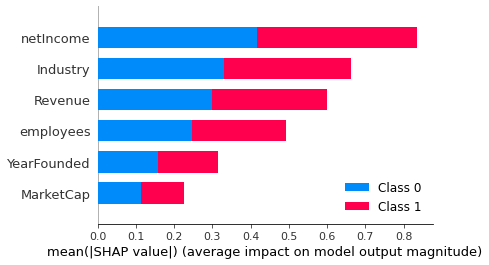

In [91]:
# Оцениваем важность фичей для модели LightGBM
import shap

shap_test = shap.TreeExplainer(best_lgb_clf.fit(X, y)).shap_values(X_new)
shap.summary_plot(shap_test, X,
                      max_display=25, plot_size=None)

[LightGBM] [Warning] feature_fraction is set=0.4130562285292044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4130562285292044
[LightGBM] [Warning] lambda_l1 is set=4.708798775577726e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.708798775577726e-07
[LightGBM] [Warning] bagging_fraction is set=0.86464328377146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86464328377146
[LightGBM] [Warning] lambda_l2 is set=0.00031651340667677205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031651340667677205
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


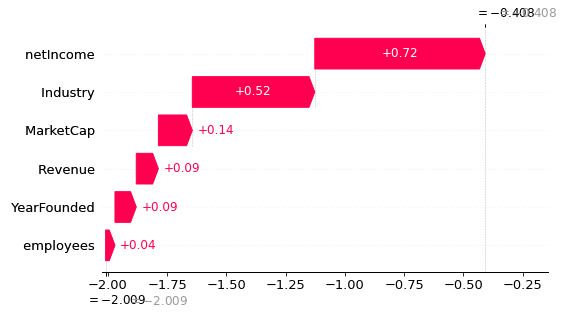

In [92]:
explainer = shap.Explainer(best_lgb_clf.fit(X, y), X)
shap_values = explainer(X_new)

shap.plots.waterfall(shap_values[0])

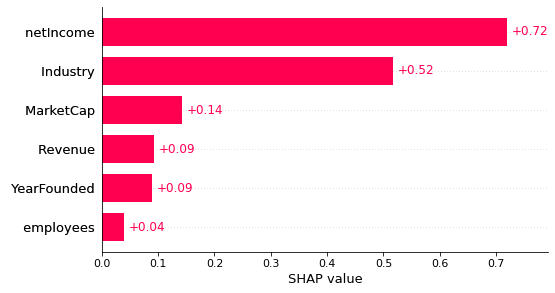

In [93]:
shap.plots.bar(shap_values[0])

In [94]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

AttributeError: 'Explanation' object has no attribute 'cohorts'